Assessing current star galaxy performance by comparing with HST data in the COSMOS field.

In [1]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import os
from astropy.table import Table, hstack, vstack
import numpy as np
from copy import deepcopy
import sys
sys.path.insert(0,'/home/sr525/Python_Code')
import match_lists


In [2]:
t_info = Table.read("/home/sr525/starGalaxy/hscFeatures_class.fits")

In [3]:
def mad(xs, med):
    
    return np.median(np.fabs(xs-med))

Approximately what is going on at the moment for star galaxy classification

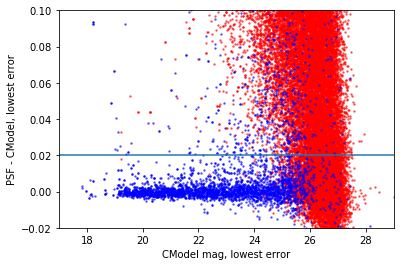

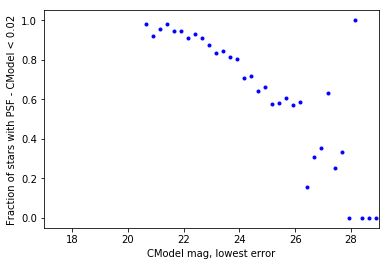

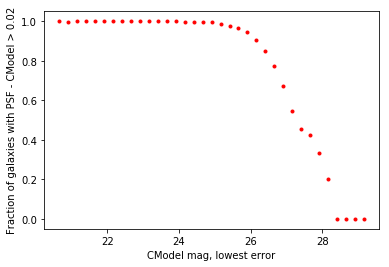

In [4]:
import matplotlib.pyplot as plt

sgl = 0.02
xs = t_info["MAG"]
ys = []

star = np.where((t_info["CLASS"] == 0))[0]
gal = np.where((t_info["CLASS"] == 1))[0]

plt.plot(xs[gal], t_info["PM"][gal], "r.", ms=3, alpha=0.5)
plt.plot(xs[star], t_info["PM"][star], "b.", ms=3, alpha=0.5)
plt.axhline(0.02)
plt.ylim(-0.02, 0.1)
plt.ylabel("PSF - CModel, lowest error")
plt.xlabel("CModel mag, lowest error")
plt.xlim(17, 29)
plt.show()

xs = np.arange(np.min(t_info["MAG"])+4.0, np.max(t_info["MAG"]), 0.25)
for (i, mag) in enumerate(xs[1:]):
    ids = np.where((t_info["CLASS"] == 0) & (t_info["PM"] < sgl) & \
                   (t_info["MAG"] < mag) & (t_info["MAG"] > xs[i]))[0]
    num = np.where((t_info["MAG"] < mag) & (t_info["CLASS"] == 0) & \
                   (t_info["MAG"] > xs[i]))[0]
    try:
        ys.append(len(ids)/len(num))
    except ZeroDivisionError:
        ys.append(0)
    
plt.plot(xs[1:], ys, "b.")
plt.ylabel("Fraction of stars with PSF - CModel < 0.02")
plt.xlabel("CModel mag, lowest error")
plt.xlim(17, 29)
plt.show()

ys = []
xs = np.arange(np.min(t_info["MAG"])+4.0, np.max(t_info["MAG"]), 0.25)
for (i, mag) in enumerate(xs[1:]):
    ids = np.where((t_info["CLASS"] == 1) & (t_info["PM"] > sgl) & \
                   (t_info["MAG"] < mag) & (t_info["MAG"] > xs[i]))[0]
    num = np.where((t_info["MAG"] < mag) & (t_info["CLASS"] == 1) & \
                   (t_info["MAG"] > xs[i]))[0]
    try:
        ys.append(len(ids)/len(num))
    except ZeroDivisionError:
        ys.append(0)
    
plt.plot(xs[1:], ys, "r.")
plt.ylabel("Fraction of galaxies with PSF - CModel > 0.02")
plt.xlabel("CModel mag, lowest error")
plt.show()


In [5]:
#Use a box-cox transform to make the data as Gaussian as possible

from sklearn.preprocessing import PowerTransformer, minmax_scale

cols_to_use = ["G", "R", "I", "Z", "Y", "GR", "RI", "IZ", "ZY", "G_PM", "R_PM", "I_PM", \
               "Z_PM", "Y_PM", "M", "B"]

features = np.zeros((len(cols_to_use), len(t_info)))

for (i, col) in enumerate(cols_to_use):
    xs = t_info[col].data
    if np.min(xs) < 0:
        xs = xs + -1.0*np.min(xs) + 1
    pt = PowerTransformer(method='box-cox', standardize=True)
    xs_trans = pt.fit_transform(xs.reshape(-1,1))
    features[i] = xs_trans.reshape(1,-1)

In [6]:
from sklearn import svm
from sklearn.preprocessing import PowerTransformer, minmax_scale

input_class = t_info["CLASS"].data

clf = svm.SVC(probability=True, class_weight={0:1})
clf = clf.fit(features.T, input_class)

In [7]:
#20% of the sample retained for testing
#Use a box-cox transform to make the data as Gaussian as possible

from sklearn.preprocessing import PowerTransformer, minmax_scale

t_test = Table.read("/home/sr525/starGalaxy/hscFeatures_test.fits")
cols_to_use = ["G", "R", "I", "Z", "Y", "GR", "RI", "IZ", "ZY", "G_PM", "R_PM", "I_PM", \
               "Z_PM", "Y_PM", "M", "B"]

features_test = np.zeros((len(cols_to_use), len(t_test)))

for (i, col) in enumerate(cols_to_use):
    xs = t_test[col].data
    if np.min(xs) < 0:
        xs = xs + -1.0*np.min(xs) + 1
    pt = PowerTransformer(method='box-cox', standardize=True)
    xs_trans = pt.fit_transform(xs.reshape(-1,1))
    features_test[i] = xs_trans.reshape(1,-1)

In [8]:
probs = clf.predict_proba(features_test.T)
predictions = clf.predict(features_test.T)

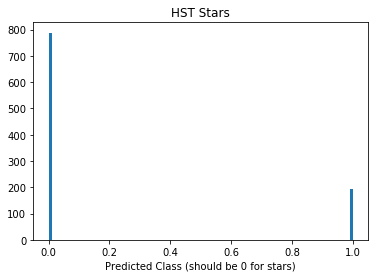

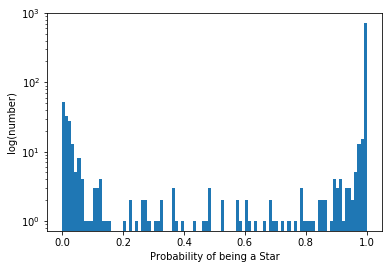

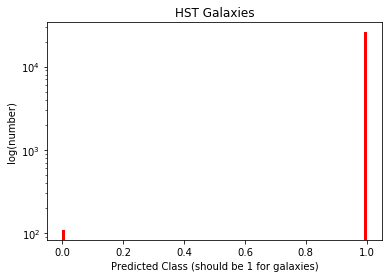

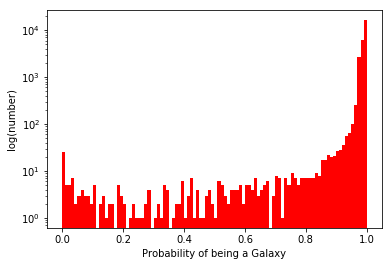

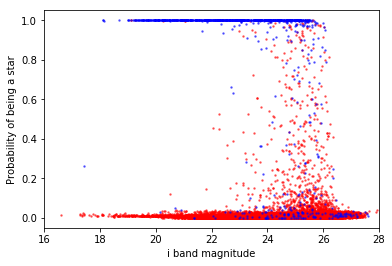

In [9]:
import matplotlib.pyplot as plt

star = np.where((t_test["CLASS"] == 0))[0]
gal = np.where((t_test["CLASS"] == 1))[0]

plt.hist(predictions[star], bins=100)
plt.title("HST Stars")
plt.xlabel("Predicted Class (should be 0 for stars)")
plt.show()

plt.hist(probs[:,0][star], bins=100)
plt.xlabel("Probability of being a Star")
plt.yscale("log")
plt.ylabel("log(number)")
plt.show()

plt.hist(predictions[gal], bins=100, color="r")
plt.title("HST Galaxies")
plt.xlabel("Predicted Class (should be 1 for galaxies)")
plt.yscale("log")
plt.ylabel("log(number)")
plt.show()

plt.hist(probs[:,1][gal], bins=100, color="r")
plt.xlabel("Probability of being a Galaxy")
plt.yscale("log")
plt.ylabel("log(number)")
plt.show()

plt.plot(t_test["MAG"][gal], probs[:,0][gal], "r.", ms=3, alpha=0.5)
plt.plot(t_test["MAG"][star], probs[:,0][star], "b.", ms=3, alpha=0.5)
plt.xlim(16.0, 28.0)
plt.xlabel("i band magnitude")
plt.ylabel("Probability of being a star")
plt.show()


HST stars classified incorrectly: 183 out of 980 ~ 19%
HST galaxies classified incorrectly: 145 out of 25956 ~ 1%


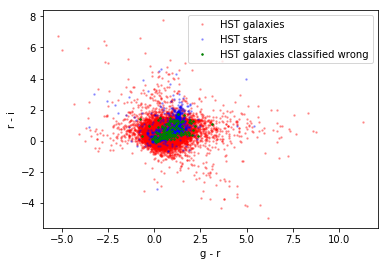

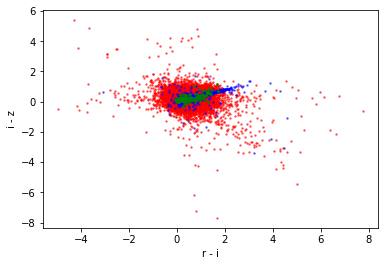

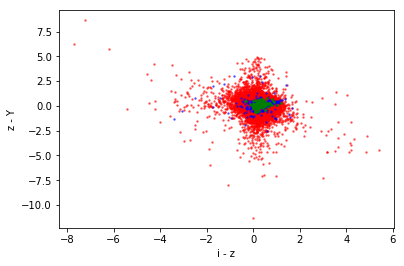

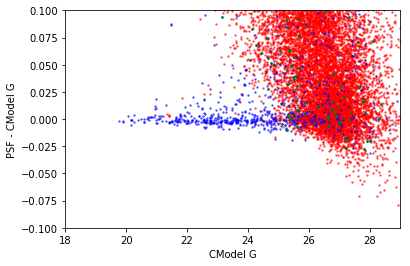

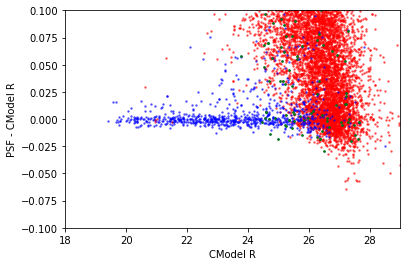

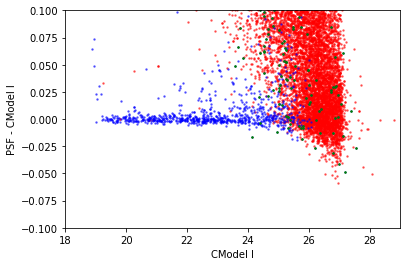

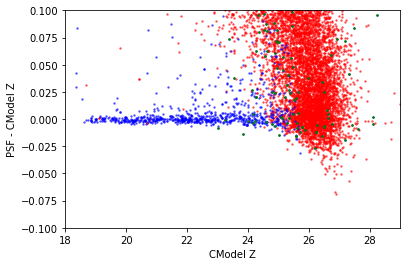

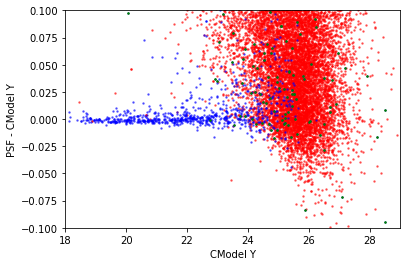

In [18]:
wrong_stars = np.where((probs[:,0] < 0.5) & (t_test["CLASS"] == 0))[0]
print("HST stars classified incorrectly:", len(wrong_stars), "out of", len(star), \
       "~ {0:.0f}%".format(len(wrong_stars)/len(star)*100))

wrong_gals = np.where((probs[:,1] < 0.5) & (t_test["CLASS"] == 1))[0]
print("HST galaxies classified incorrectly:", len(wrong_gals), "out of", len(gal), \
      "~ {0:.0f}%".format(len(wrong_gals)/len(gal)*100))

plt.plot(t_test["GR"][gal], t_test["RI"][gal], "r.", ms=3, alpha=0.3, label="HST galaxies")
plt.plot(t_test["GR"][star], t_test["RI"][star], "b.", ms=3, alpha=0.3, label="HST stars")
plt.plot(t_test["GR"][wrong_gals], t_test["RI"][wrong_gals], "g.", ms=3, \
         label="HST galaxies classified wrong")
plt.legend(loc="best")
plt.xlabel("g - r")
plt.ylabel("r - i")
plt.show()

plt.plot(t_test["RI"][gal], t_test["IZ"][gal], "r.", ms=3, alpha=0.5)
plt.plot(t_test["RI"][star], t_test["IZ"][star], "b.", ms=3, alpha=0.5)
plt.plot(t_test["RI"][wrong_gals], t_test["IZ"][wrong_gals], "g.", ms=3)
plt.xlabel("r - i")
plt.ylabel("i - z")
plt.show()

plt.plot(t_test["IZ"][gal], t_test["ZY"][gal], "r.", ms=3, alpha=0.5)
plt.plot(t_test["IZ"][star], t_test["ZY"][star], "b.", ms=3, alpha=0.5)
plt.plot(t_test["IZ"][wrong_gals], t_test["ZY"][wrong_gals], "g.", ms=3)
plt.xlabel("i - z")
plt.ylabel("z - Y")
plt.show()

for band in ["G", "R", "I", "Z", "Y"]:
    plt.plot(t_test[band][gal], t_test[band + "_PM"][gal], "r.", ms=3, alpha=0.5)
    plt.plot(t_test[band][star], t_test[band + "_PM"][star], "b.", ms=3, alpha=0.5)
    plt.plot(t_test[band][wrong_stars], t_test[band + "_PM"][wrong_stars], "g.", ms=3)
    plt.ylim(-0.1, 0.1)
    plt.xlabel("CModel " + band)
    plt.ylabel("PSF - CModel " + band)
    plt.xlim(18,29)
    plt.show()
    